In [44]:
#Libraries
import pandas as pd #Bibliothek für Datenmanipulation und -analyse
import numpy as np #Bibliothek für mathematische Funktionen
import matplotlib.pyplot as plt #Bibliothek zum Erstellen von statischen, animierten und interaktiven Visualisierungen
import seaborn as sns #Bibliothek für statistische Datenvisualisierung basierend auf matplotlib
# knn
from sklearn.neighbors import KNeighborsClassifier #K-Nearest Neighbors Klassifikator aus scikit-learn
from sklearn import neighbors #Modul für K-Nearest Neighbors Algorithmen
from sklearn.model_selection import cross_val_score #Funktion zur Bewertung eines Scores durch Kreuzvalidierung
from sklearn.preprocessing import StandardScaler #Standardisiert Merkmale, indem der Mittelwert entfernt und auf die Einheitsskala skaliert wird
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV #Funktion zum Aufteilen von Arrays oder Matrizen in zufällige Trainings- und Testsätze
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay #Modul zur Berechnung von Klassifikationsmetriken
from mlxtend.plotting import plot_decision_regions #Funktion zum Plotten von Entscheidungsregionen von Klassifikatoren
# Principle Component Analysis (PCA)
from sklearn.decomposition import PCA #Hauptkomponentenanalyse (PCA) aus scikit-learn
# Entscheidungsbaum
from sklearn.tree import DecisionTreeClassifier #Entscheidungsbaum-Klassifikator aus scikit-learn
# Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #Random Forest Klassifikator aus scikit-learn
#Neurnales Netz
from tensorflow.keras.models import Sequential #Sequenzielles Modell aus Keras, einer High-Level-API für neuronale Netze
from tensorflow.keras.utils import to_categorical #Funktion zur Umwandlung eines Klassenvektors (Ganzzahlen) in eine binäre Klassenmatrix
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization #Dichte (vollständig verbundene) Schicht aus Keras, Dropout-Schicht aus Keras, Batch-Normalisierungsschicht aus Keras
from tensorflow.keras.callbacks import EarlyStopping #Callback zum Stoppen des Trainings, wenn eine überwachte Metrik sich nicht mehr verbessert
import tensorflow as tf
import random
# Support Vector Machine (SVM)
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import label_binarize


# CSV-Datei einlesen
telefonkunden = pd.read_csv('telefonkunden.csv')

# Wie sieht der Datensatz aus?
print(telefonkunden.head())

   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3  


In [5]:
# Metainformationen 
telefonkunden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [6]:
# Daten kennenlernen

# Mit dem Befehl describe() können summary statistics aufgerufen werden:
telefonkunden.describe()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000


In [7]:
category_counts = telefonkunden['custcat'].value_counts()

# Ausgabe der Anzahl der Kategorien und Einträge für custcat
print("Anzahl der Kategorien:", len(category_counts))
print("Anzahl der Einträge in jeder Kategorie:")
print(category_counts)

Anzahl der Kategorien: 4
Anzahl der Einträge in jeder Kategorie:
custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64


Durchschnittliches Einkommen nach Kundengruppe:
custcat
1    54.759398
2    74.834101
3    89.032028
4    92.000000
Name: income, dtype: float64


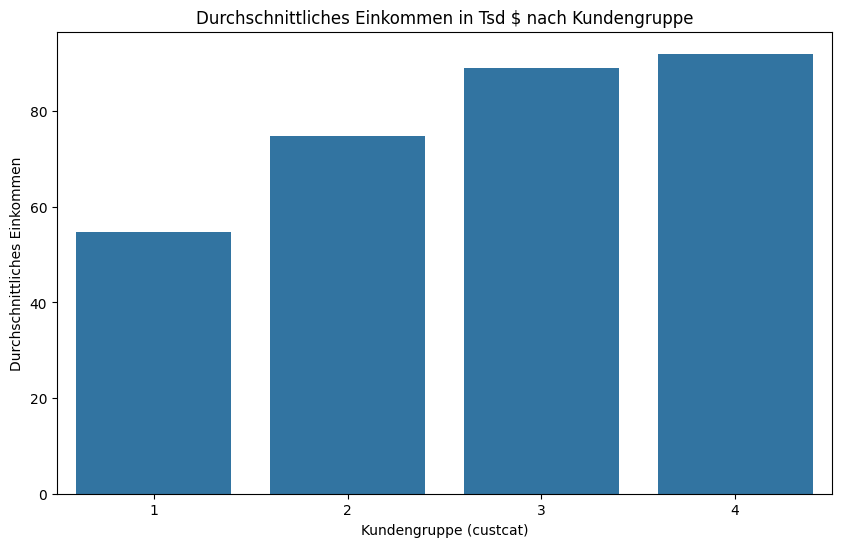

Durchschnittliche Zugehörigkeitsdauer nach Kundengruppe:
custcat
1    24.676692
2    43.345622
3    40.078292
4    35.144068
Name: tenure, dtype: float64


In [8]:
# Durchschnittliches Einkommen nach Kundengruppe (custcat) berechnen
avg_income_by_custcat = telefonkunden.groupby('custcat')['income'].mean()

# Ergebnis anzeigen
print("Durchschnittliches Einkommen nach Kundengruppe:")
print(avg_income_by_custcat)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_income_by_custcat.index, y=avg_income_by_custcat.values)
plt.title('Durchschnittliches Einkommen in Tsd $ nach Kundengruppe')
plt.xlabel('Kundengruppe (custcat)')
plt.ylabel('Durchschnittliches Einkommen')
plt.show()

# Durchschnittliche Zugehörigkeitsdauer (tenure) nach Kundengruppe berechnen
avg_tenure_by_custcat = telefonkunden.groupby('custcat')['tenure'].mean()

# Ergebnis anzeigen
print("Durchschnittliche Zugehörigkeitsdauer nach Kundengruppe:")
print(avg_tenure_by_custcat)

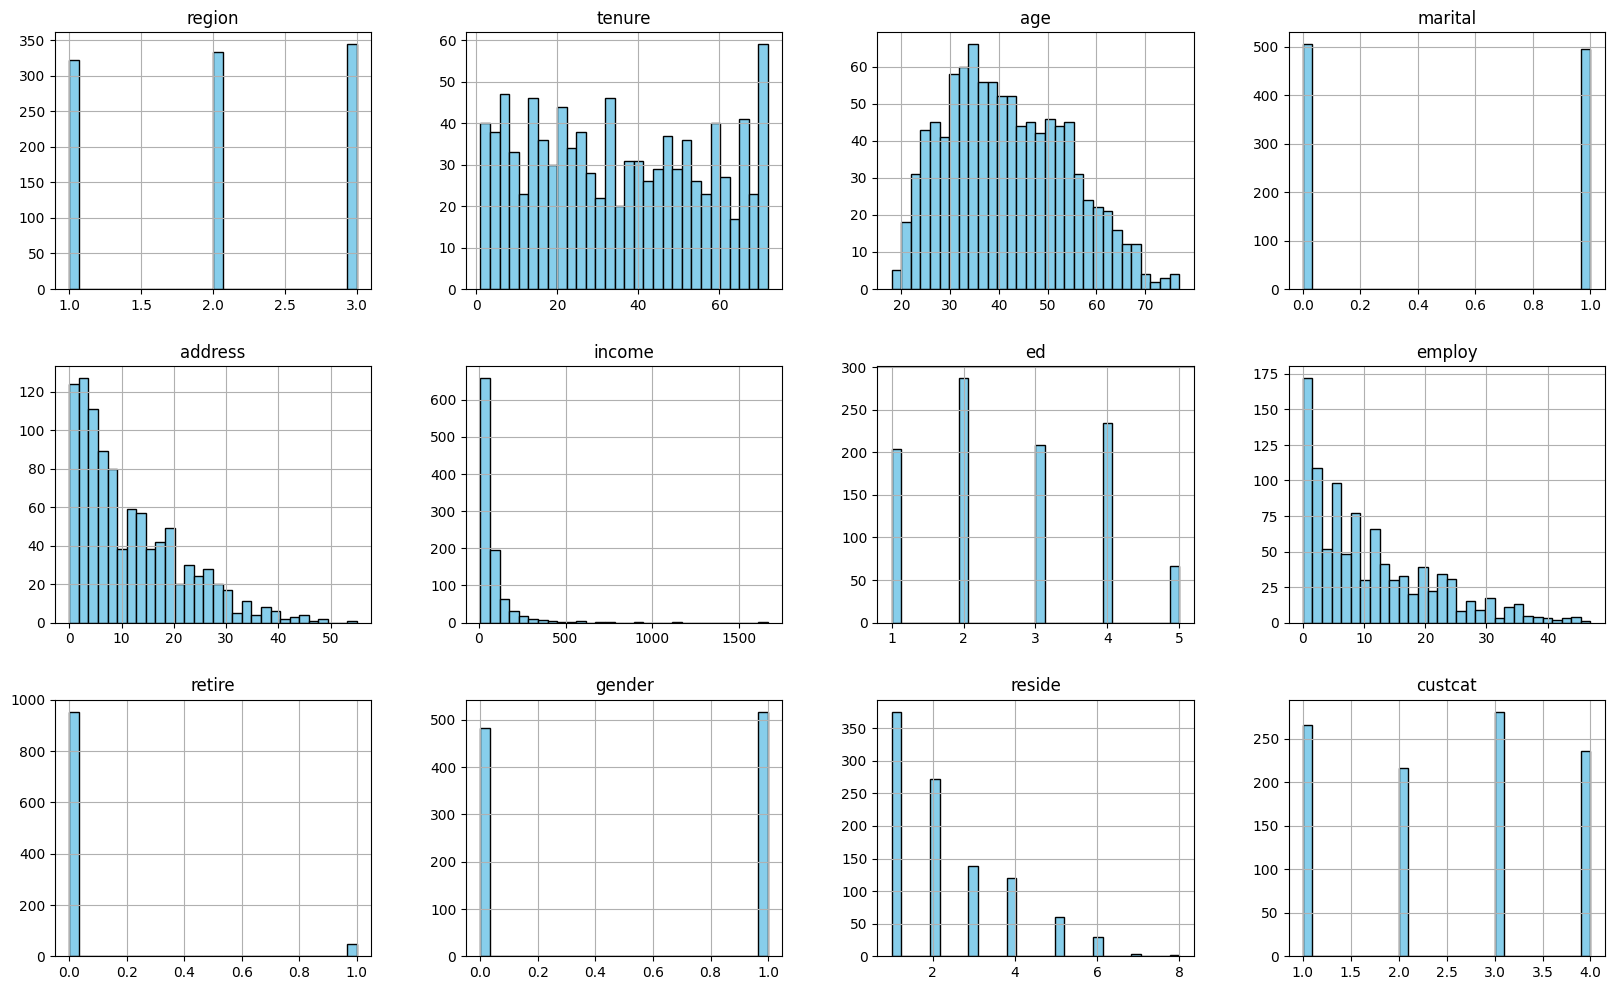

In [9]:
# Verteilung der Daten anzeigen
telefonkunden.hist(figsize=(20, 12), bins=30, color='skyblue', edgecolor='black', layout=(3, 4))
numeric_cols = telefonkunden.select_dtypes(include=['number']).columns

In [10]:
###### K-Nearest Neighbors (KNN) ######

In [15]:
# den Datensatz in Trainings- und Lerndatensatz aufteilen

# Dafür erstellen wir zunächst (wie auch bei den Weinen) zwei separate Datensätze mit den Input- (X) und der Outputvariablen (Y)
X = telefonkunden.drop(columns=['custcat'])
Y = telefonkunden.custcat
X.head()
Y.head()

# Jetzt können wir wieder mit train_test_split aus scikit-learn den Datensatz in Trainings- und Testdaten aufteilen

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)
# Wie vorher: Wir teilen in 20% Lern- und 80% Testdaten auf (test_size), lassen die Aufteilung zur Reproduzierbarkeit der Ergebnisse immer gleich aufteilen (random_state) und sorgen dafür, dass die Klassen gleichmäßig aufgeteilt sind (stratify).

# Nun wird das Modelll trainiert. Wir verwenden zunächst k=5 Nachbarn.
knn = KNeighborsClassifier(n_neighbors = 5)
vorhersage_scikit = knn.fit(X_training, Y_training)

In [16]:
# eine Vorhersage mit dem kNN-Algorithmus treffen
vorhersage_scikit=knn.predict(X_test)

In [17]:
#Ergebnis 
knn.score(X_test, Y_test)

0.335

In [19]:
# Die bisherige Vorgehensweise hieß Holdout-Methode: Man reserviert eine Menge als Testdaten, den Rest als Trainingsdaten. Allerdings kann dies zu Probleme führen: 
# Vielleicht wurden die Daten unglücklich aufgeteilt?Zur Lösung bedient man sich der sog. k-fache Kreuzvalidierung, wie auch in der Vorlesung besprochen.
# Bei der Kreuzvalidierung wird der Datensatz zufällig in Gruppen aufgeteilt. Eine der Gruppen wird als Testsatz und der Rest als Trainingssatz verwendet. 
# Das Modell wird mit dem Trainingssatz trainiert und mit dem Testsatz bewertet. Dann wird der Prozess wiederholt, bis jede einzelne Gruppe als Testsatz verwendet wurde. 
# Bei der 5-fachen Kreuzvalidierung werden also die Daten in 5 Gruppen aufgeteilt und 5-mal angepasst und bewertet, wobei jedes Mal der Genauigkeitswert in einem Array abgespeichert wird. So hat jede der 5 Gruppen eine Chance, als Testdatensatz zu dienen.
# Neuen Klassifikator verwenden, mit unserem idealen k=5
klassifikator_kreuzvalidierung = KNeighborsClassifier(n_neighbors=13)

# Genauigkeiten mit einem trainierten Modell mit 5 Gruppen
kreuzvalidierung_genauigkeiten = cross_val_score(klassifikator_kreuzvalidierung, X, Y, cv = 5)

# Genauigkeiten ausgeben
print(kreuzvalidierung_genauigkeiten)
print(np.mean(kreuzvalidierung_genauigkeiten))
# Wir konnten also eine Erhöhung der Genauigkeit erreichen!

[0.395 0.32  0.285 0.35  0.405]
0.35100000000000003


In [23]:
# Definieren wir zunächst einen neuen Klassifikator:
knn2 = KNeighborsClassifier()

# Hyperparameter-Optimimerung
k_grid = {'n_neighbors': np.arange(1, 50)}

# Nun lassen wir die Grid-Suche für jedes k durchlaufen, jeweils mit einer 5-fachen Kreuzvalidierung:
knn_grid = GridSearchCV(knn2, k_grid, cv = 5)

# Nun trainieren wir das Modell mit den Daten und den darüber definierten Parametern:
knn_grid.fit(X, Y)

# Was ist nun die beste Anzahl an Nachbarn?
print(knn_grid.best_params_)

# Der Genauigkeits-Score bei dieser Anzahl an Nachbarn ist nochmal höher
knn_grid.best_score_

{'n_neighbors': np.int64(42)}


np.float64(0.365)

In [24]:
# Man kann die Funktion auch alle Genauigkeits-Scores ausgeben lassen. Dies sind also für jedes k die durchschnittlichen Werte der Genauigkeits-Scores aus je allen 5 Durchläufen der Kreuzvalidierung!
scores = knn_grid.cv_results_['mean_test_score']
print(scores)

[0.291 0.301 0.307 0.312 0.31  0.316 0.312 0.323 0.326 0.329 0.327 0.33
 0.351 0.331 0.344 0.338 0.324 0.335 0.339 0.33  0.336 0.341 0.339 0.35
 0.35  0.35  0.348 0.358 0.353 0.351 0.35  0.342 0.354 0.353 0.343 0.35
 0.348 0.352 0.348 0.358 0.358 0.365 0.36  0.351 0.354 0.354 0.355 0.361
 0.361]


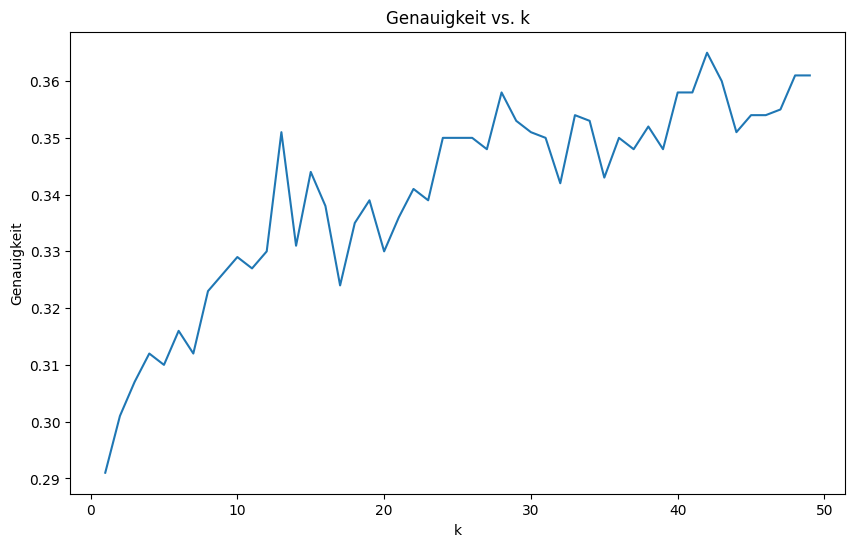

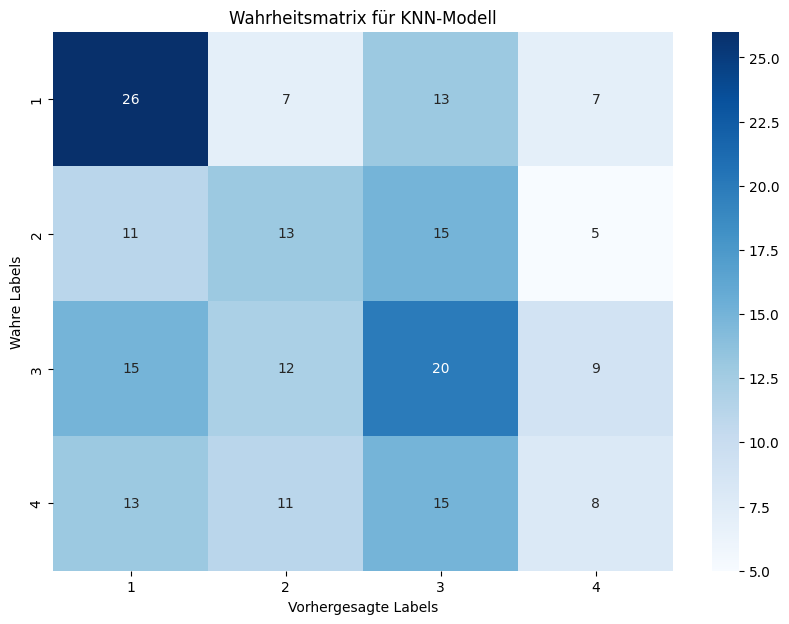

In [25]:
plt.figure(figsize=(10,6))
# Wir plotten auf der x-Achse von 1 bis 49 (also die k's die wir oben in der for-Schleife durchprobiert haben)
plt.plot(range(1, len(scores) + 1), scores)
plt.title('Genauigkeit vs. k')
plt.xlabel('k')
plt.ylabel('Genauigkeit')

# Wahrheitsmatrix für das KNN-Modell
conf_matrix = confusion_matrix(Y_test, vorhersage_scikit)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix für KNN-Modell')
plt.show()

In [ ]:
###################### KNN mit ausgewählten Variablen #################################

0.395
[0.345, 0.325, 0.38, 0.355, 0.335, 0.33, 0.355, 0.335, 0.35, 0.31, 0.345, 0.34, 0.38, 0.355, 0.36, 0.36, 0.38, 0.39, 0.395, 0.375, 0.37, 0.39, 0.37, 0.38, 0.385, 0.385, 0.36, 0.35, 0.335, 0.35, 0.345, 0.345, 0.335, 0.35, 0.36, 0.35, 0.365, 0.38, 0.395, 0.38, 0.385, 0.375, 0.355, 0.35, 0.35, 0.35, 0.36, 0.365, 0.355, 0.36, 0.355, 0.36, 0.365, 0.365, 0.375, 0.37, 0.375, 0.38, 0.38, 0.37, 0.365, 0.37, 0.385, 0.39, 0.37, 0.385, 0.4, 0.39, 0.38, 0.39, 0.385, 0.385, 0.38, 0.385, 0.385, 0.395, 0.39, 0.385, 0.39, 0.385, 0.38, 0.39, 0.37, 0.39, 0.405, 0.38, 0.385, 0.37, 0.36, 0.36, 0.36, 0.355, 0.35, 0.35, 0.36, 0.36, 0.365, 0.375, 0.385]


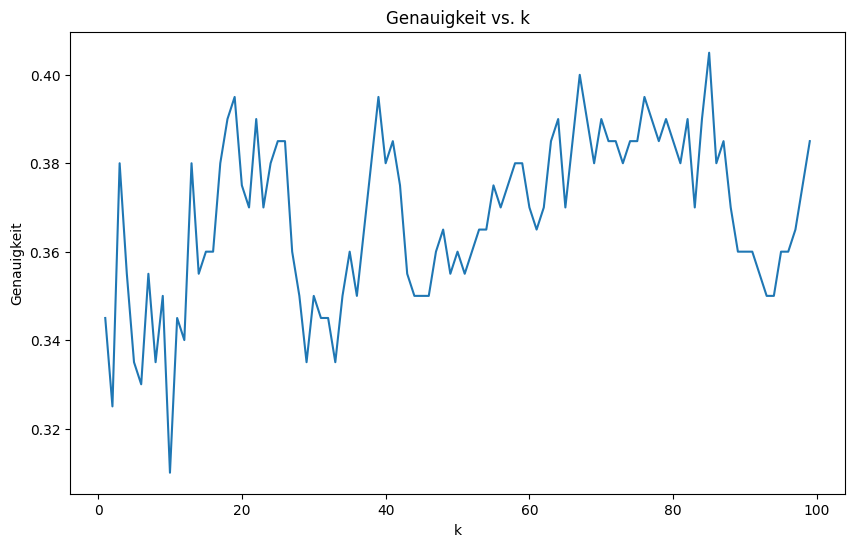

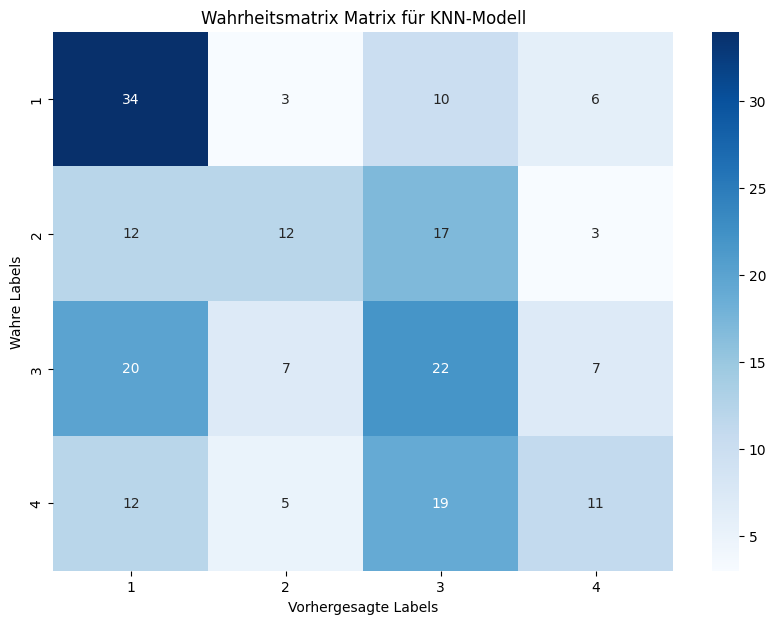

In [26]:
# Merkmale und Zielvariable definieren
X = telefonkunden[['tenure','age','income','address','employ','ed']] # Merkmale, die für die Vorhersage von 'custcat' relevant sind
Y = telefonkunden['custcat']

# Daten in Trainings- und Testset aufteilen 80/20 Split|Stratified --> gleiche Verteilung der Zielvariable
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# KNN-Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=19)  # Anzahl der Nachbarn 
vorhersage_scikit = knn.fit(X_training, Y_training)

vorhersage_scikit = knn.predict(X_test)

# Genauigkeit der Vorhersage
print(accuracy_score(Y_test, vorhersage_scikit))

# Berechnung der Genauigkeit für verschiedene Werte von n_neighbors
scores = []
for k in range(1, 100):
	knn = KNeighborsClassifier(n_neighbors=k)
	knn.fit(X_training, Y_training)
	y_pred = knn.predict(X_test)
	scores.append(accuracy_score(Y_test, y_pred))

# Berechnung der Genauigkeit für verschiedene Werte von n_neighbors
scores = []
for k in range(1, 100):
	knn = KNeighborsClassifier(n_neighbors=k)
	knn.fit(X_training, Y_training)
	y_pred = knn.predict(X_test)
	scores.append(accuracy_score(Y_test, y_pred))

# Ausgabe der Genauigkeits-Scores
print(scores)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), scores)
plt.title('Genauigkeit vs. k')
plt.xlabel('k')
plt.ylabel('Genauigkeit')
plt.show()

# Wahrheits Matrix
conf_matrix = confusion_matrix(Y_test, vorhersage_scikit)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix Matrix für KNN-Modell')
plt.show()

Beste Hyperparameter für KNN: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
Beste KNN Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.38      0.38      0.38        53
           2       0.45      0.39      0.41        44
           3       0.43      0.50      0.46        56
           4       0.39      0.36      0.37        47

    accuracy                           0.41       200
   macro avg       0.41      0.41      0.41       200
weighted avg       0.41      0.41      0.41       200

Beste KNN Genauigkeit: 0.41


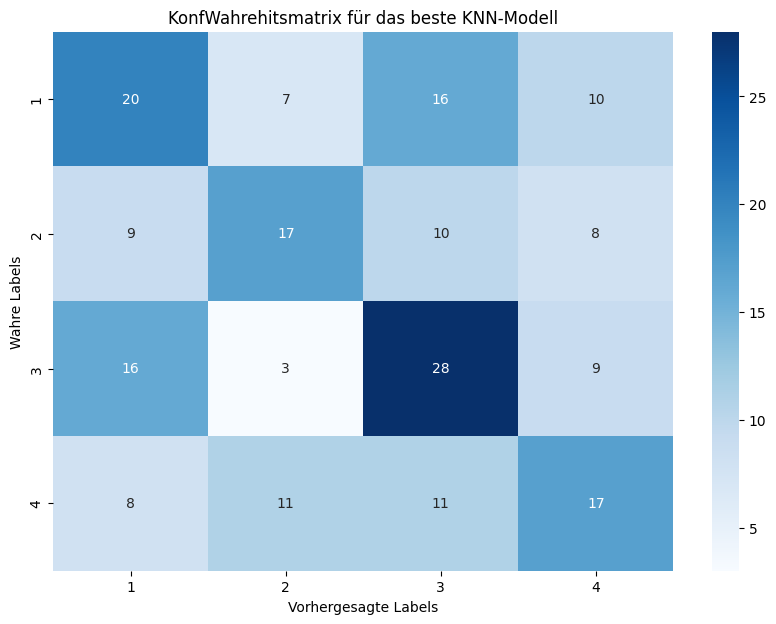

In [ ]:
#### Hyperparameter-Tuning mit GridSearchCV für KNN mit ausgewählten Variablen####

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure', 'age', 'income', 'ed', 'gender', 'address']]  # Auswahl der relevanten Merkmale
y = telefonkunden['custcat']  # Zielvariable

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Aufteilung der Daten in Trainings- und Testset

# Feature-Skalierung
scaler = StandardScaler()  # Initialisierung des StandardScalers
X_train = scaler.fit_transform(X_train)  # Anpassung und Transformation der Trainingsdaten
X_test = scaler.transform(X_test)  # Transformation der Testdaten

# Hyperparameter-Raster für KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],  # Anzahl der Nachbarn
    'weights': ['uniform', 'distance'],  # Gewichtung der Nachbarn
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distanzmetriken
}

# GridSearchCV-Objekt für KNN erstellen
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')  # Initialisierung von GridSearchCV mit KNN und Hyperparameter-Raster

# GridSearchCV auf Trainingsdaten anwenden
grid_search_knn.fit(X_train, y_train)  # Training des Modells mit GridSearchCV

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter für KNN:", grid_search_knn.best_params_)  # Ausgabe der besten Hyperparameter

# Bestes Modell aus GridSearchCV extrahieren
best_knn = grid_search_knn.best_estimator_  # Extraktion des besten Modells

# Vorhersagen mit dem besten Modell machen
y_pred_best_knn = best_knn.predict(X_test)  # Vorhersagen für die Testdaten

# Klassifikationsbericht für das beste Modell anzeigen
print("Beste KNN Klassifikationsbericht:")  # Ausgabe des Klassifikationsberichts
print(classification_report(y_test, y_pred_best_knn))  # Klassifikationsbericht anzeigen

# Genauigkeit des besten Modells anzeigen
print("Beste KNN Genauigkeit:", accuracy_score(y_test, y_pred_best_knn))  # Ausgabe der Genauigkeit des Modells

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahreheitsmatrix für das beste KNN-Modell')
plt.show()

In [28]:
### Normalisierung der Daten ###

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'address']]
y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature-Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# k-NN Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Vorhersagen machen
y_pred = knn.predict(X_test)

# Modellbewertung
print("k-NN Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("k-NN Genauigkeit:", accuracy_score(y_test, y_pred))

k-NN Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.38      0.53      0.44        53
           2       0.37      0.41      0.39        44
           3       0.49      0.46      0.48        56
           4       0.42      0.21      0.28        47

    accuracy                           0.41       200
   macro avg       0.41      0.40      0.40       200
weighted avg       0.42      0.41      0.40       200

k-NN Genauigkeit: 0.41


In [29]:
### Principal Component Analysis (PCA) ###
# PCA ist eine Methode zur Reduzierung der Dimensionalität eines Datensatzes, indem die Anzahl der Variablen reduziert wird.
# Die Daten werden in eine neue Koordinatensystem transformiert, das aus den Hauptkomponenten besteht.
# Die Hauptkomponenten sind die Richtungen, in denen die Daten am meisten variieren.
# Die Hauptkomponenten sind orthogonal zueinander, d.h. sie sind unkorreliert.
# Die Hauptkomponenten sind eine lineare Kombination der ursprünglichen Variablen.
# Die Hauptkomponenten sind so gewählt, dass die erste Hauptkomponente die größte Varianz aufweist, die zweite Hauptkomponente die zweitgrößte Varianz usw.

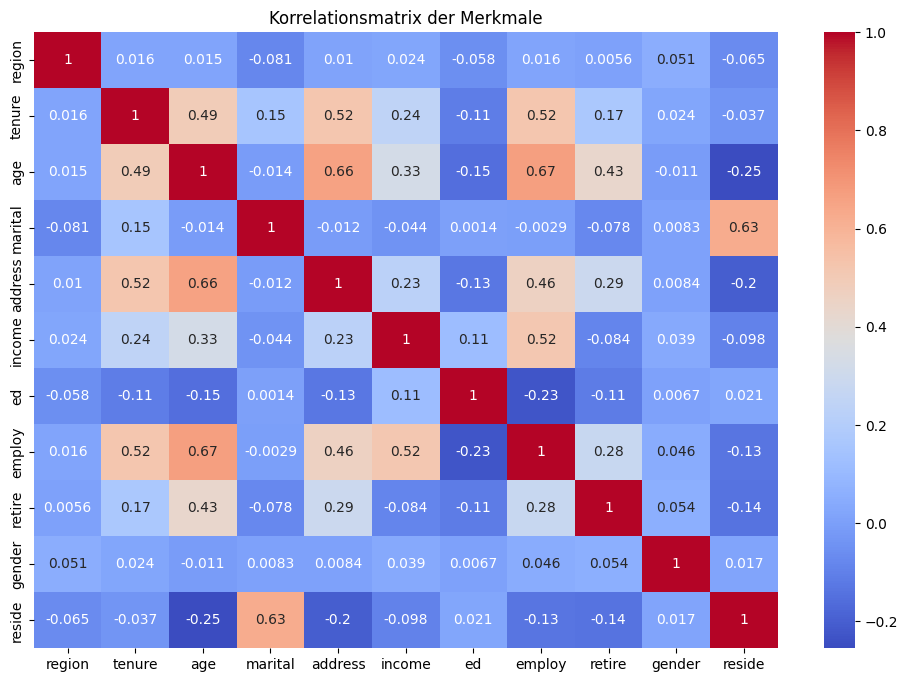

Erklärte Varianz durch die Hauptkomponenten: [0.28627756 0.15034329]


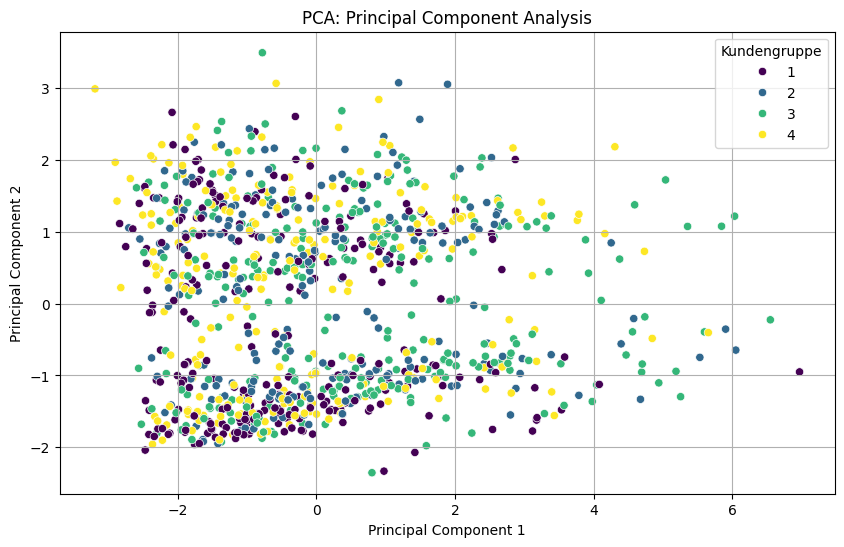

In [31]:
# Datenvorbereitung: Kategorische Variablen kodieren
telefonkunden['gender'] = telefonkunden['gender'].astype('category').cat.codes
telefonkunden['region'] = telefonkunden['region'].astype('category').cat.codes
telefonkunden['marital'] = telefonkunden['marital'].astype('category').cat.codes
telefonkunden['ed'] = telefonkunden['ed'].astype('category').cat.codes
telefonkunden['retire'] = telefonkunden['retire'].astype('category').cat.codes

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden.drop('custcat', axis=1)
y = telefonkunden['custcat']

# Korrelationen überprüfen
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der Merkmale')
plt.show()

# Feature-Skalierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA-Objekt erstellen und Anzahl der Komponenten festlegen
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Erstellen eines DataFrames mit den PCA-Ergebnissen
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['custcat'] = y.values

# Ausgabe der erklärten Varianz durch die Hauptkomponenten
print("Erklärte Varianz durch die Hauptkomponenten:", pca.explained_variance_ratio_)

# Plot der Hauptkomponenten
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='custcat', data=pca_df, palette='viridis')
plt.title('PCA: Principal Component Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Kundengruppe')
plt.grid(True)
plt.show()

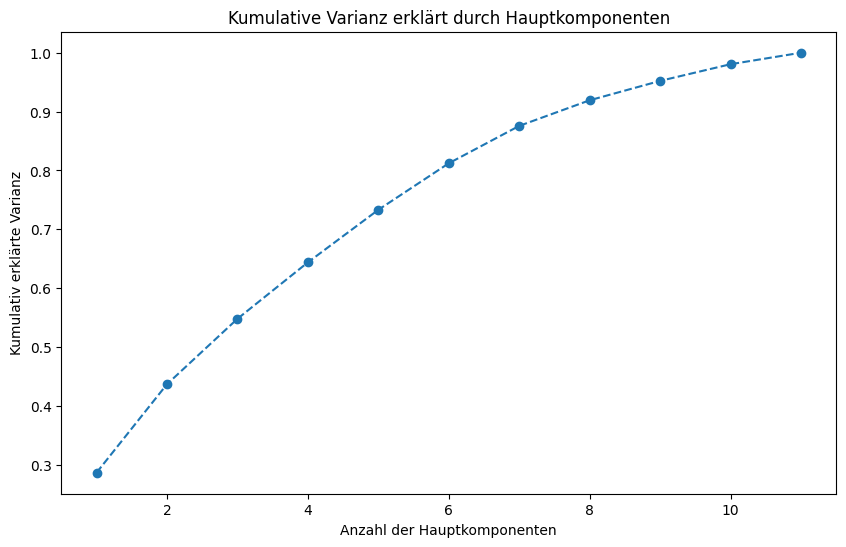

In [32]:
# PCA durchführen
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Daten standardisieren
scaler = StandardScaler()
X = telefonkunden.drop('custcat', axis=1)
X = scaler.fit_transform(X)

# PCA durchführen
pca = PCA()
X_pca = pca.fit_transform(X)

# Varianz erklärt durch die Hauptkomponenten
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot der kumulativen Varianz
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Anzahl der Hauptkomponenten')
plt.ylabel('Kumulativ erklärte Varianz')
plt.title('Kumulative Varianz erklärt durch Hauptkomponenten')
plt.show()

Genauigkeit des k-NN-Modells: 0.325
              precision    recall  f1-score   support

           1       0.35      0.45      0.39        60
           2       0.18      0.21      0.19        39
           3       0.39      0.40      0.40        55
           4       0.35      0.17      0.23        46

    accuracy                           0.33       200
   macro avg       0.32      0.31      0.30       200
weighted avg       0.33      0.33      0.32       200



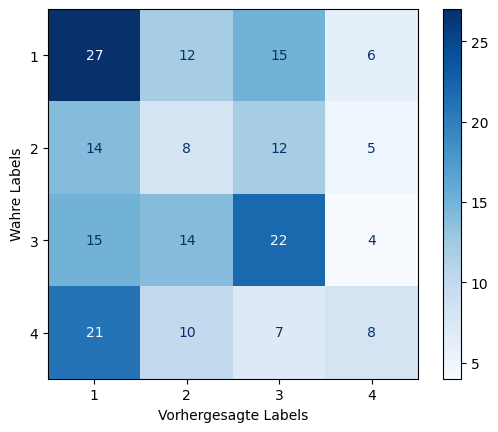

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


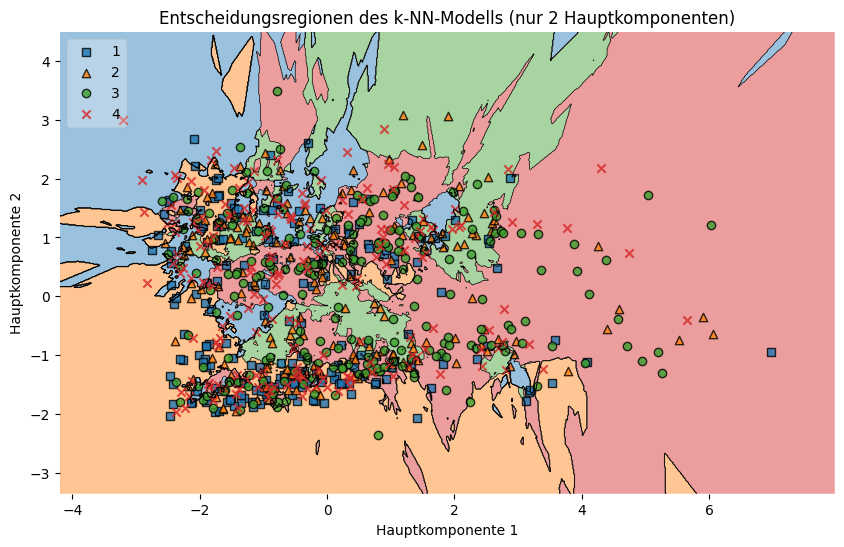

In [33]:
# Die ersten 7 Hauptkomponenten erklären etwa 90% der Varianz im Datensatz
# Wir können also die ersten 7 Hauptkomponenten verwenden, um den Datensatz zu reduzieren

# PCA mit 7 Hauptkomponenten durchführen
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

# Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_pca, telefonkunden['custcat'], test_size=0.2, random_state=42)

# 2. Klassifikation mit k-Nearest Neighbors (k-NN)

# Modell trainieren
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Vorhersagen für Testdaten
y_pred = knn.predict(X_test)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit des k-NN-Modells:", accuracy)

# Klassifikationsbericht
print(classification_report(y_test, y_pred))

# Wahrheitsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.show()

# Entscheidungsregionen plotten (nur für die ersten 2 Hauptkomponenten)
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train[:, :2], y_train.values, clf=KNeighborsClassifier(n_neighbors=19).fit(X_train[:, :2], y_train), legend=2)
plt.xlabel('Hauptkomponente 1')
plt.ylabel('Hauptkomponente 2')
plt.title('Entscheidungsregionen des k-NN-Modells (nur 2 Hauptkomponenten)')
plt.show()

In [34]:
##################### Random Forest #####################
# Random Forest ist ein Ensemble (mehrere "Lernende" werden auf das selbe Ziel trainier)-Lernalgorithmus, der aus mehreren Entscheidungsbäumen besteht.
# Jeder Baum im Wald wird auf einem zufälligen Unterdatensatz des Datensatzes trainiert.

Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.47      0.57      0.51        53
           2       0.40      0.27      0.32        44
           3       0.39      0.45      0.42        56
           4       0.36      0.32      0.34        47

    accuracy                           0.41       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.41      0.41      0.40       200

Genauigkeit: 0.41


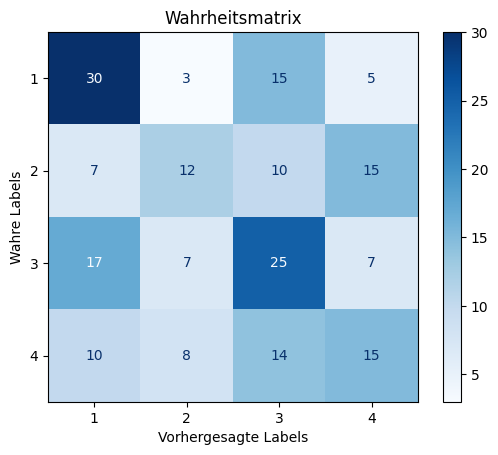

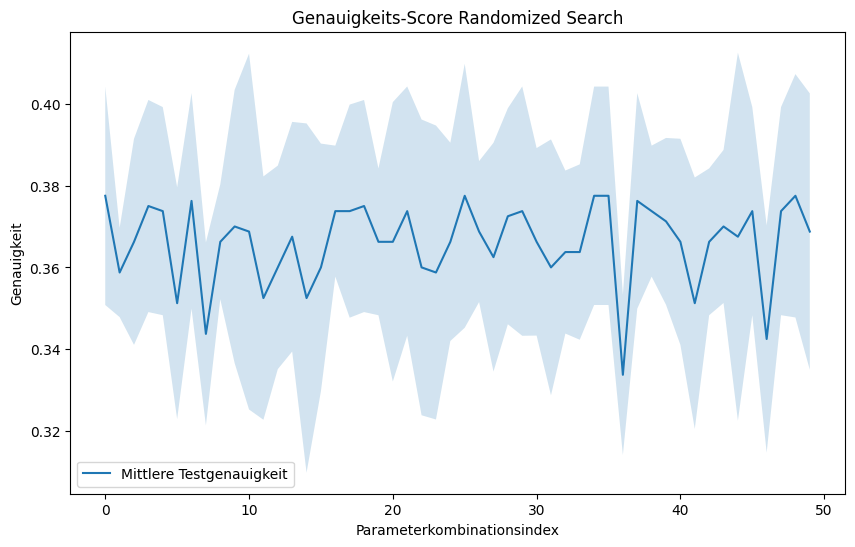

In [53]:
#Random Forest Test - 41% Genauigkeit
telefonkunden = pd.read_csv('telefonkunden.csv')


selected_features = ['region', 'tenure', 'age', 'income', 'ed', 'employ', 'reside']

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[selected_features]
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Hyperparameter-Tuning für den Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=1), param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_rf = random_search.best_estimator_

# Vorhersagen machen
y_pred = best_rf.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("Genauigkeit:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Wahrheitsmatrix')
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.show()

# Plot Genauigkeit
results = random_search.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(results['mean_test_score'], label='Mittlere Testgenauigkeit')
plt.fill_between(range(len(results['mean_test_score'])), 
                 results['mean_test_score'] - results['std_test_score'], 
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2)
plt.title('Genauigkeits-Score Randomized Search')
plt.xlabel('Parameterkombinationsindex')
plt.ylabel('Genauigkeit')
plt.legend()
plt.show()

Beste Hyperparameter für Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Beste Random Forest Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.40      0.38      0.39        53
           2       0.45      0.32      0.37        44
           3       0.41      0.52      0.46        56
           4       0.42      0.43      0.42        47

    accuracy                           0.41       200
   macro avg       0.42      0.41      0.41       200
weighted avg       0.42      0.41      0.41       200

Beste Random Forest Genauigkeit: 0.415


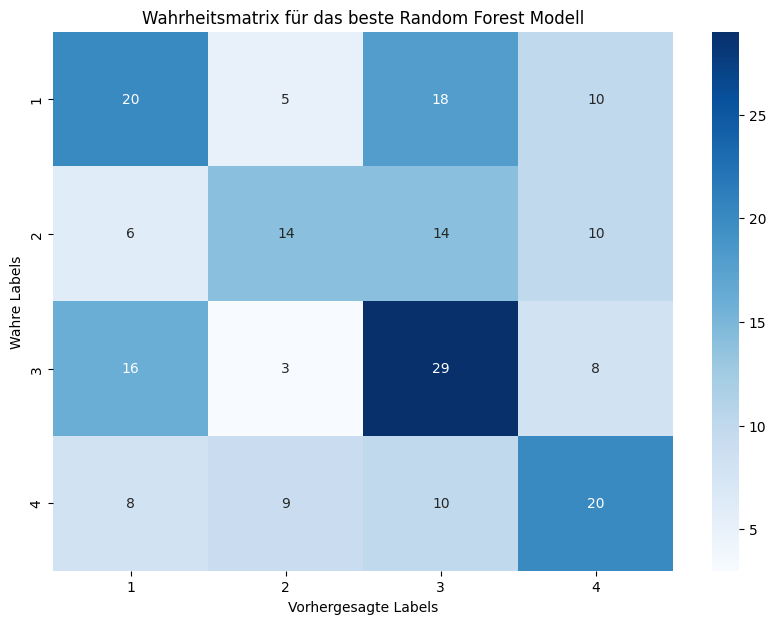

In [52]:
# Hyperparameter-Raster für Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV-Objekt für Random Forest erstellen
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# GridSearchCV auf Trainingsdaten anwenden
grid_search_rf.fit(X_train, y_train)

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter für Random Forest:", grid_search_rf.best_params_)

# Bestes Modell aus GridSearchCV extrahieren
best_rf = grid_search_rf.best_estimator_

# Vorhersagen mit dem besten Modell machen
y_pred_best_rf = best_rf.predict(X_test)

# Modellbewertung
print("Beste Random Forest Klassifikationsbericht:")
print(classification_report(y_test, y_pred_best_rf))
print("Beste Random Forest Genauigkeit:", accuracy_score(y_test, y_pred_best_rf))

# Konfusionsmatrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix für das beste Random Forest Modell')
plt.show()

In [38]:
##################### Neuronales Netz #####################
# Ein neuronales Netz ist ein Modell, das aus einer Reihe von miteinander verbundenen Neuronen besteht, die in Schichten organisiert sind.
# Jedes Neuron nimmt Eingaben, führt eine Berechnung durch und gibt eine Ausgabe weiter. Die Ausgaben der Neuronen in einer Schicht werden an die nächste Schicht weitergegeben.
# Neuronale Netze können verwendet werden, um komplexe nichtlineare Beziehungen in den Daten zu modellieren und Vorhersagen zu treffen.

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Neuronales Netz Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.42      0.55      0.48        53
           2       0.50      0.32      0.39        44
           3       0.45      0.52      0.48        56
           4       0.39      0.32      0.35        47

    accuracy                           0.43       200
   macro avg       0.44      0.43      0.42       200
weighted avg       0.44      0.43      0.43       200

Neuronales Netz Genauigkeit: 0.435


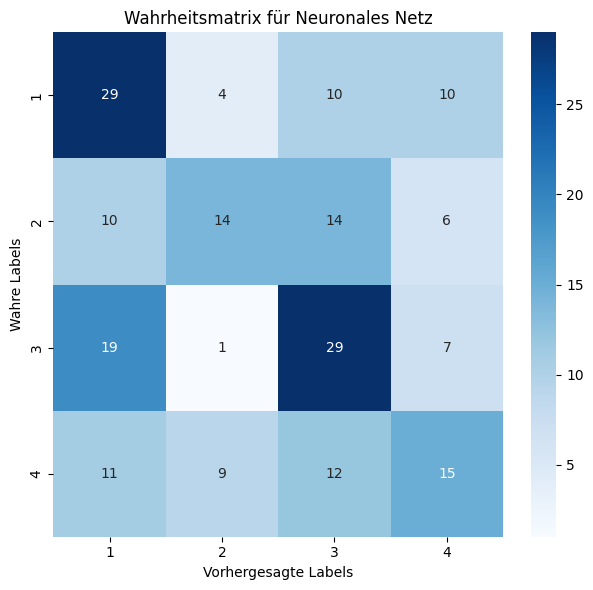

In [48]:
# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']]  # Auswahl der relevanten Features
y = telefonkunden['custcat']  # Zielvariable

# Zielvariable in kategorische Form umwandeln
y = to_categorical(y)  

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Aufteilung der Daten in Trainings- und Testset

# Feature-Skalierung
scaler = StandardScaler()  # Initialisierung des StandardScalers
X_train = scaler.fit_transform(X_training)  # Anpassung und Transformation der Trainingsdaten
X_test = scaler.transform(X_test)  # Transformation der Testdaten

# Neuronales Netz erstellen
model = Sequential()  # Initialisierung des Modells
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Hinzufügen der ersten Schicht mit 64 Neuronen und ReLU-Aktivierung (Aktivierungsfunktion)
model.add(Dense(32, activation='relu'))  # Hinzufügen der zweiten Schicht mit 32 Neuronen und ReLU-Aktivierung
model.add(Dense(Y_training.shape[1], activation='softmax'))  # Hinzufügen der Ausgabeschicht mit Softmax-Aktivierung

# Modell kompilieren
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Kompilierung des Modells (Backporpagation)

# Modell trainieren
model.fit(X_train, Y_training, epochs=50, validation_data=(X_test, Y_test), verbose=0)  # Training des Modells (Backpropagation)

# Vorhersagen machen
y_pred = model.predict(X_test)  # Vorhersagen für die Testdaten (feedforward)
y_pred_classes = y_pred.argmax(axis=1)  # Umwandlung der Vorhersagen in Klassen
y_test_classes = Y_test.argmax(axis=1)  # Umwandlung der Testdaten in Klassen

# Modellbewertung
print("Neuronales Netz Klassifikationsbericht:")  # Ausgabe des Klassifikationsberichts
print(classification_report(y_test_classes, y_pred_classes))  # Klassifikationsbericht anzeigen
print("Neuronales Netz Genauigkeit:", accuracy_score(y_test_classes, y_pred_classes))  # Genauigkeit des Modells 

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
conf_matrix_nn = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes))
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix für Neuronales Netz')

plt.tight_layout()
plt.show()


In [ ]:
##################### NN Optimierungen #####################

# Batch Normalization: Die Batch-Normalisierungsschichten (BatchNormalization()) helfen, die Trainingsstabilität zu verbessern und die Konvergenz zu beschleunigen.
# Dropout: Die Dropout-Schichten (Dropout(0.5)) helfen, Überanpassung zu vermeiden, indem sie zufällig Neuronen während des Trainings deaktivieren.
# Early Stopping: Der Early Stopping Callback (EarlyStopping) beendet das Training, wenn sich die Validierungsleistung nicht mehr verbessert, um Überanpassung zu vermeiden.
# Erweiterte Optimierer: Der Adam-Optimierer (optimizer='adam') wird verwendet, um die Lernrate adaptiv anzupassen.

In [46]:
# Zufallszahlen initialisieren
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']]
y = telefonkunden['custcat']

# Zielvariable in kategorische Form umwandeln
y = to_categorical(y)

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature-Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neuronales Netz erstellen
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())  # Batch-Normalisierung hinzufügen
model.add(Dropout(0.5))  # Dropout-Schicht hinzufügen
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Batch-Normalisierung hinzufügen
model.add(Dropout(0.5))  # Dropout-Schicht hinzufügen
model.add(Dense(y_train.shape[1], activation='softmax'))

# Modell kompilieren
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modell trainieren
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Vorhersagen machen
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Modellbewertung
print("Optimiertes Neuronales Netz Klassifikationsbericht:")
print(classification_report(y_test_classes, y_pred_classes))
print("Optimiertes Neuronales Netz Genauigkeit:", accuracy_score(y_test_classes, y_pred_classes))

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Optimiertes Neuronales Netz Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.43      0.51      0.47        53
           2       0.38      0.20      0.26        44
           3       0.41      0.48      0.44        56
           4       0.45      0.45      0.45        47

    accuracy                           0.42       200
   macro avg       0.41      0.41      0.40       200
weighted avg       0.42      0.42      0.41       200

Optimiertes Neuronales Netz Genauigkeit: 0.42


In [42]:
############# Support Vector Machine ################
# Ist ein überwachtes maschinelles Lernverfahren, das sowohl für Klassifikationsprobleme als auch für Regressionsaufgaben eingesetzt werden kann
# Besonders effektiv bei der Trennung von Daten in hochdimensionalen Räumen
# SVMs finden die Trennlinie, die die Klassen im Raum am besten trennt

Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.53      0.58      0.55        53
           2       0.56      0.23      0.32        44
           3       0.36      0.46      0.41        56
           4       0.47      0.51      0.49        47

    accuracy                           0.46       200
   macro avg       0.48      0.45      0.44       200
weighted avg       0.47      0.46      0.45       200

Genauigkeit: 0.455


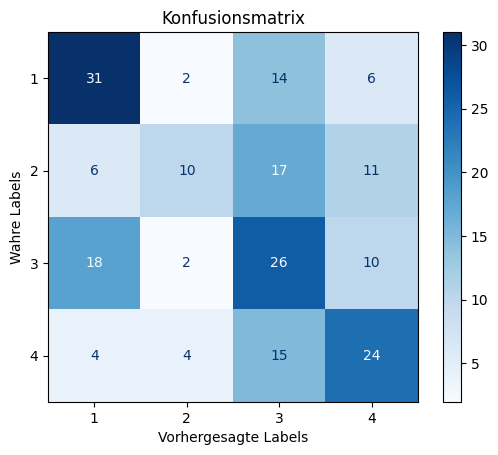

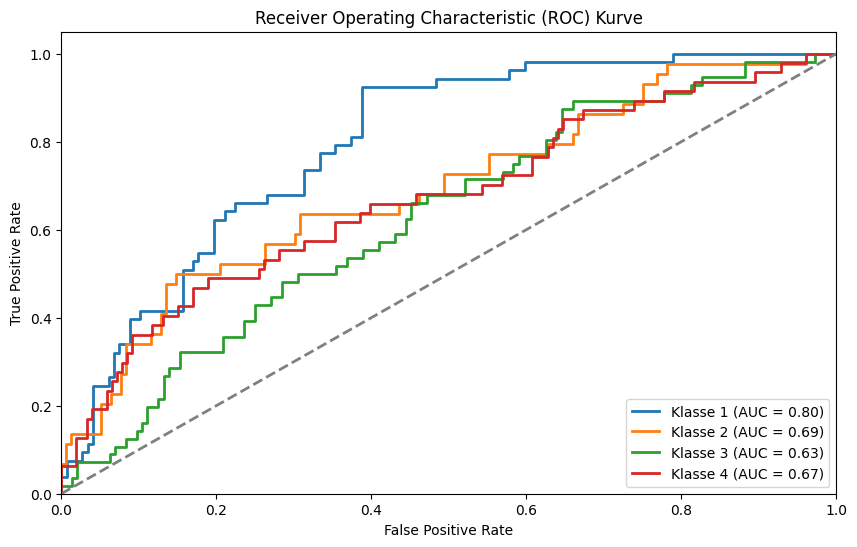

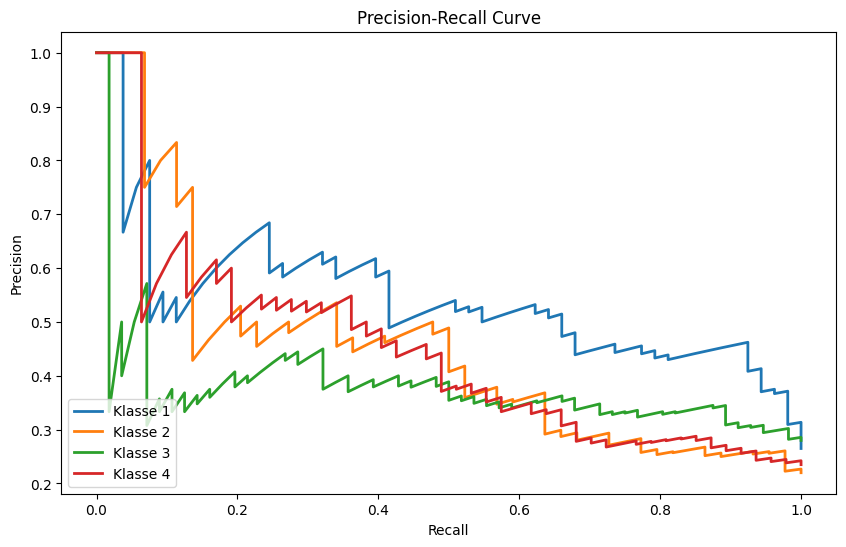

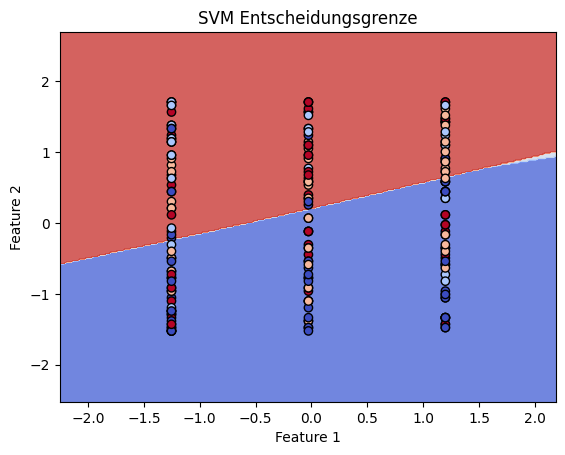

In [43]:
# SVM 45,5% Genauigkeit


# Ausgewählte Features mit tatsächlichen Spaltennamen definieren
selected_features = ['region', 'tenure', 'age', 'income', 'ed', 'employ', 'reside']

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[selected_features]
Y = telefonkunden['custcat']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=1, stratify=Y)

# Hyperparameter-Tuning für den SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(random_state=1, probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_svm = grid_search.best_estimator_

# Vorhersagen machen
y_pred = best_svm.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("Genauigkeit:", accuracy_score(y_test, y_pred))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.show()

# ROC Curve und Precision-Recall Curve für jede Klasse berechnen
y_test_binarized = label_binarize(y_test, classes=np.unique(Y))
y_prob = best_svm.predict_proba(X_test)

# ROC Curve
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i], pos_label=1)
    roc_auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label='Klasse %d (AUC = %0.2f)' % (i + 1, roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Kurve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label='Klasse %d' % (i + 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Entscheidungsgrenze visualisieren (funktioniert nur, wenn wir auf 2 Features reduzieren)
def plot_decision_boundary(X, y, model):
    h = .02  # Schrittweite im Mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Entscheidungsgrenze')
    plt.show()

# Reduzieren auf 2 Features zur Visualisierung
X_reduced = X_scaled[:, :2]
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, Y, test_size=0.2, random_state=1, stratify=Y)

# Trainiere den SVM auf reduzierten Features
grid_search_reduced = GridSearchCV(SVC(random_state=1), param_grid, cv=5, scoring='accuracy')
grid_search_reduced.fit(X_train_reduced, y_train_reduced)
best_svm_reduced = grid_search_reduced.best_estimator_

# Plot der Entscheidungsgrenze
plot_decision_boundary(X_test_reduced, y_test_reduced, best_svm_reduced)